<a href="https://colab.research.google.com/github/yananma/5_programs_per_day/blob/master/02125.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 9.2 微调

### 9.2.1 热狗识别

In [0]:
%matplotlib inline 
import torch 
from torch import nn, optim, utils 
from torch.utils.data import Dataset, DataLoader 
import torchvision 
from torchvision.datasets import ImageFolder 
from torchvision import transforms 
from torchvision import models 
import os 
import d2l 
import zipfile
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 1 获取数据集

In [0]:
!mkdir ../data

In [0]:
!pip install mxnet

In [0]:
from mxnet.gluon import utils as gutils 

In [12]:
data_dir = '../data'
base_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/'
fname = gutils.download(
    base_url + 'gluon/dataset/hotdog.zip', 
    path=data_dir, sha1_hash='fba480ffa8aa7e0febbb511d181409f899b9baa5'
)
with zipfile.ZipFile(fname, 'r') as z:
    z.extractall(data_dir)

In [0]:
train_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/train'))
test_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/test'))

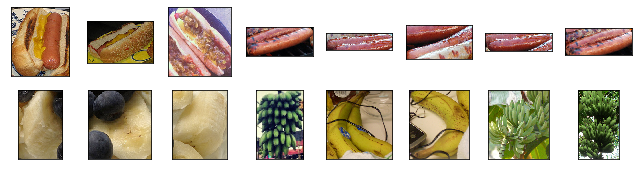

In [15]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_augs = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

test_augs = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])

#### 2 定义和初始化模型

In [0]:
pretrained_net = models.resnet18(pretrained=True)

In [26]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [27]:
pretrained_net.fc = nn.Linear(512, 2)
pretrained_net.fc

Linear(in_features=512, out_features=2, bias=True)

In [0]:
output_params = list(map(id, pretrained_net.fc.parameters()))
feature_params = filter(lambda p: id(p) not in output_params, pretrained_net.parameters())

lr = 0.01 
optimizer = optim.SGD([{'params': feature_params}, 
            {'params': pretrained_net.fc.parameters(), 'lr': lr * 10}], 
            lr=lr, weight_decay=0.001)

#### 3 微调模型

In [0]:
def train_fine_tuning(net, optimizer, batch_size=128, num_epochs=5):
    train_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/train'), transform=train_augs), 
                batch_size, shuffle=True)
    test_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/test'), transform=test_augs), 
                batch_size)
    loss = torch.nn.CrossEntropyLoss()
    d2l.train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

In [30]:
train_fine_tuning(pretrained_net, optimizer)

training on  cuda
epoch 1, loss 4.4294, train acc 0.664, test acc 0.912, time 25.6 sec
epoch 2, loss 0.2100, train acc 0.906, test acc 0.910, time 25.4 sec
epoch 3, loss 0.0667, train acc 0.939, test acc 0.896, time 25.4 sec
epoch 4, loss 0.0547, train acc 0.930, test acc 0.906, time 25.3 sec
epoch 5, loss 0.0604, train acc 0.919, test acc 0.905, time 25.5 sec


In [31]:
scratch_net = models.resnet18(pretrained=False, num_classes=2)
lr = 0.1 
optimizer = optim.SGD(scratch_net.parameters(), lr=lr, weight_decay=0.001)
train_fine_tuning(scratch_net, optimizer)

training on  cuda
epoch 1, loss 2.4687, train acc 0.607, test acc 0.790, time 25.4 sec
epoch 2, loss 0.2170, train acc 0.794, test acc 0.818, time 25.3 sec
epoch 3, loss 0.1319, train acc 0.817, test acc 0.851, time 25.3 sec
epoch 4, loss 0.0910, train acc 0.846, test acc 0.844, time 25.3 sec
epoch 5, loss 0.0685, train acc 0.857, test acc 0.839, time 25.3 sec
